# Let’s make a DQN: Debugging

https://gym.openai.com/envs/MountainCar-v0/

Some useful resources:
  * https://jaromiru.com/2016/10/12/lets-make-a-dqn-debugging/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from tensorflow.keras import models, layers, optimizers
from replay_buffer import ReplayBuffer
from IPython.display import clear_output
%matplotlib inline

# 1. Explore environment

Observation shape: (2,)
Number of actions: 2
Example state: [-0.54055684  0.        ]


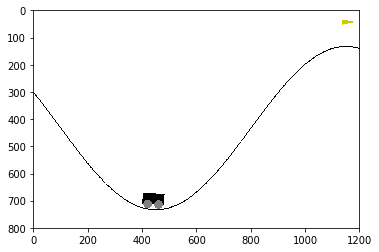

In [2]:
#spawn game instance for tests
env = gym.make("MountainCar-v0").env #create raw env

observation_shape = env.observation_space.shape
n_actions = 2 # We simplify to left and right action

print("Observation shape: {}".format(observation_shape))
print("Number of actions: {}".format(n_actions))

print("Example state: {}".format(env.reset()))
plt.imshow(env.render('rgb_array'))

## 1.1. How many random steps are needed to solve it

In [3]:
def solve_randomly():
    env.reset()
    for step in range(100_000):
        a = np.random.choice([0, 2])
        s_next, r, done, info = env.step(a)
        if done:
            break
    return step
            
## Look for 10 solution using random policy
solution_steps = []
for _ in range(10):
    steps = solve_randomly()
    solution_steps.append(steps)
    
print('Mean number of steps: {} (std={})'.format(np.mean(solution_steps), np.std(solution_steps)))

Mean number of steps: 16801.3 (std=15607.085269517816)


# 2. Prepare

## 2.1. Hyperparameters

In [7]:
LEARNING_RATE = 0.0003
REPLAY_BUFFER_SIZE = 100_000

BATCH_SIZE = 64

GAMMA = 0.99

MAX_EPSILON = 1
MIN_EPSILON = 0.1
LAMBDA = 0.001      # speed of the decay

## 2.2. Helper functions

### 2.2.1. Normalize environment

In [8]:
# Encode action
def encode_action(a):
    return a if a == 0 else 2



## 2.2.2. Memory buffer and training set

#FIXME: Check if reward is calculated correctly

In [9]:
def build_training_set(qvalues, qvalues_next, actions, rewards, dones, gamma=0.99):
    """
    Create training set for QNetwork.
    Params:
      qvalues           - Q values for the starting state
      qvalues_next      - Q values for the state the next state
      actions           - Actions taken
      rewards           - Rewards received after taking action 
      dones             - Did this action end the episode?
      
    Returns:
      Expected qvalues
    """
    y = qvalues.copy()
    next_rewards = np.where(dones, np.zeros(rewards.shape), np.max(qvalues_next, axis=1))
    y[np.arange(y.shape[0]), actions] = rewards + gamma * next_rewards
    return y


# Some tests
qvalues = np.zeros((5, n_actions))
qvalues2 = np.ones((5, n_actions))
actions = np.array([0, 1, 0, 1, 0])
rewards = np.array([1, 2, 3, 4, 5])
dones = np.array([False, False, False, False, True])
expected_y = np.array([[2, 0], [0, 3], [4, 0], [0, 5], [5, 0]])
y = build_training_set(qvalues, qvalues2, actions, rewards, dones, 1.0)
assert np.array_equal(y, expected_y), 'Wrong expected qvalue calculated'
print('Ok!')

Ok!


## 2.3. DQN Agent

### 2.3.1. Define Policy Network

In [11]:
class QNetwork:
    
    def __init__(self, input_shape, n_actions, alpha=LEARNING_RATE):
        self.input_shape = input_shape
        self.output_shape = n_actions
        self.alpha = alpha
        self.model = self._build_network()

    def _build_network(self):
        model = models.Sequential()
        model.add(layers.InputLayer(self.input_shape))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(self.output_shape, activation='linear'))
        opt = optimizers.RMSprop(lr=self.alpha)
        model.compile(loss='mse', optimizer=opt)
        return model
    
    def predict(self, state):
        """Make prediction for single state and return q values for all actions"""
        s = np.expand_dims(state, axis=0)
        return self.model.predict(s)[0]
    
    def predict_batch(self, states):
        """Make prediction for list of states"""
        return self.model.predict(states)
    
    def train(self, x, y):
        self.model.fit(x, y, batch_size=64, verbose=0)

        
network = QNetwork(observation_shape, n_actions)
network.predict(env.reset())

array([0.10341555, 0.08274443], dtype=float32)

### 2.3.2 Define Agent

In [12]:
class DQNAgent:
    
    def __init__(self, network, replays=ReplayBuffer(REPLAY_BUFFER_SIZE)):
        self.memory_capacity = 100000
        self.epsilon_min = 0.01
        self.epsilon_max = 0.01
        self.epsilon_lambda = 0.001
        self.batch_size = 64
        self.epsilon = self.epsilon_max        
        self.model = network
        self.replays = replays
        self.step = 0
        
    def collect_policy(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, network.output_shape)
        else:
            qvalues = self.model.predict(state)
            action = np.argmax(qvalues)
            self.step += 1
        self.epsilon = self.epsilon_min + (self.epsilon_max-self.epsilon_min) * np.power(np.e, self.epsilon_lambda*self.step)
        return action
    
    def add_observation(self, state, action, reward, next_state, is_done):
        self.replays.add(state, action, reward, next_state, is_done)
        
    def train(self):
        states, actions, rewards, states_next, dones = self.replays.sample(self.batch_size)
        qvalues = self.model.predict_batch(states)
        qvalues_next = self.model.predict_batch(states_next)
        y = build_training_set(qvalues, qvalues_next, actions, rewards, dones)
        self.model.train(states, y)
    
    
network = QNetwork(observation_shape, n_actions)
agent = DQNAgent(network)
s1 = env.reset()
a = agent.policy(s1)
s2, r, d, _ = env.step(a)
agent.add_observation(s1, a, r, s2, d)
agent.train()
a

1

## 2.4. Training loops

In [26]:
def train_on_episode(env, agent, t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    state = env.reset()
    
    for t in range(t_max):
        action = agent.collect_policy(state)
        encoded_action = encode_action(action)
        next_state, reward, done, info = env.step(encoded_action)
        agent.add_observation(state, action, reward, next_state, done)
        agent.train()
        total_reward += reward
        state = next_state
        if done: break
            
    return total_reward


def train_agent(env, agent, max_episodes=2000, t_max=200, solved=199.0):

    #generate new sessions
    rewards = []
    for i in range(1, max_episodes+1):
        session_reward = train_on_episode(env, agent, t_max)
        rewards.append(session_reward)
        if i % 100 == 0:
            mean_score = np.mean(rewards[-100:])
            clear_output(True)
            print('Step: {}, mean reward: {}'.format(i, mean_score))
            plt.plot(rewards)
            plt.show()
            if mean_score > solved:
                print("Solved in {} steps".format(i))
                break
    return rewards

# Test
agent = RandomAgent(n_actions)
train_agent(env, agent, max_episodes=1, t_max=100, solved=-90)

[-100.0]

## 3. Debugging

### 3.1. Generate episodes using random policy

In [25]:
replays = ReplayBuffer(REPLAY_BUFFER_SIZE)
env.reset()
dones = 0
for step in range(REPLAY_BUFFER_SIZE):
    a = np.random.choice([0, 2])
    s_next, r, done, info = env.step(a)
    if done:
        dones += 1
        env.reset()
            
print('Solved {} times'.format(dones))

Solved 9 times


### 3.2. Train inital agent

### 3.3. Q function visualization

### 3.4. Value function visualization